<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# Занятие 8. Apache Spark
## Домашнее задание. Анализ веб-логов. Решение

#### Анализ веб-логов - частый случай использования Apache Spark, поскольку логов много, данные часто разреженные. Но с помощью данных из лог-файлов можно улучшать веб-сервисы, рекомендательные системы, обнаружтвать подозрительных пользователей и т.д.

#### План:
#### *Часть 1*: Формат лог-файлов
#### *Часть 2*: Пример анализа лог-файлов
#### *Часть 3*: Анализ серверных лог-файлов
#### *Часть 4*: Исследование запросов с кодом ответа 404

### **Часть 1: Формат лог-файлов**
#### Записи в логах в формате Apache [Common Log Format](http://httpd.apache.org/docs/1.3/logs.html#common) выглядят так:
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
#### Подробнее:
* `127.0.0.1`

IP-адрес клиента, сделавшего запрос на сервер.
 
* `-`

Дефисы означают, что личность клиента, сделавшего запрос на сервер, не идентифицирована .
 
* `[01/Aug/1995:00:00:01 -0400]`

Время окончания обработки запроса сервером. Формат:
`[day/month/year:hour:minute:second timezone]`

  * day = 2 цифры
  * month = 3 буквы
  * year = 4 цифры
  * hour = 2 цифры
  * minute = 2 цифры
  * second = 2 цифры
  * zone = (\+ | \-) 4 цифры
 
* `"GET /images/launch-logo.gif HTTP/1.0"`

Первая строка запроса клиента.Тип запроса (`GET`, `POST` и т.д.), [URI](http://en.wikipedia.org/wiki/Uniform_resource_identifier) ресурса, и версия протокола клиента.
 
* `200`

Код статуса, возвращенный сервером. Успешные начинаются с 2, перенаправление запроса - с 3, ошибочные со стороны клиента запросы - с 4, ошибочные со стороны сервера запросы - с 5. 
 
* `1839`

Размер объекта, возвращенного клиенту. Если ничего не было возвращено - это "-" или 0.
 
 
### HTTP серверные веб-логи NASA
#### Используем данные WWW-сервера NASA Kennedy Space Center. [Данные](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) включают статистику HTTP-запросов за 2 месяца.

### **Предобработка строк лог-файла**
#### Используя регулярные выражения, выберем строки, удовлетворяющие описанному выше шаблону

In [1]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [5]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN =  '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

### **Создание RDD**
#### Функция `parseApacheLogLine` возвращает кортежи с объектом Row и индикатором того, что соответствующая строка попала под шаблон регулярного выражения. 

In [6]:
import sys
import os

logFile = logFile = '../../data/NASA_logs'

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print('Number of invalid logline: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print('Invalid logline: %s' % line)

    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' 
          % (parsed_logs.count(), access_logs.count(), failed_logs.count()))
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Read 383304 lines, successfully parsed 383304 lines, failed to parse 0 lines


### **Часть 2: Пример анализа лог-файлов**
 
#### **Статистика объема контента**

In [7]:
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print('Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max()))

Content Size Avg: 17599, Min: 0, Max: 3155499


#### **Анализ кодов ответа сервера**

In [8]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print('Found %d response codes' % len(responseCodeToCountList))
print('Response Code Counts: %s' % responseCodeToCountList)

Found 7 response codes
Response Code Counts: [(200, 344346), (304, 30725), (404, 1940), (500, 2), (302, 6249), (403, 37), (501, 5)]


#### **Отображение статистики кодов ответа с `matplotlib`**
#### Посчитаем доли, приходящиеся на каждый код ответа, и используем Pie-chart.

In [9]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print(labels)
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print(fracs)

[200, 304, 404, 500, 302, 403, 501]
[0.898362657316386, 0.0801583077661595, 0.005061256861394611, 5.217790578757331e-06, 0.01630298666332728, 9.652912570701062e-05, 1.3044476446893327e-05]


Populating the interactive namespace from numpy and matplotlib


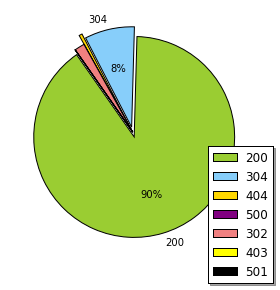

In [10]:
%pylab inline

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
legend(labels, loc=(0.80, -0.1), shadow=True)

#### **Частые адреса**

In [11]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print('Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20)
# An example: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']

Any 20 hosts that have accessed more then 10 times: [u'stevef.ihs.com', u'200.255.255.126', u'204.243.249.9', u'163.205.11.133', u'198.53.144.164', u'202.40.17.51', u'205.217.103.69', u'194.64.130.208', u'becks.oe.fau.edu', u'joeyt.pdial.interpath.net', u'204.174.243.61', u'dialup2.speed.net', u'163.206.112.26', u'pc-117.grassroots.ns.ca', u'152.52.29.20', u'141.225.240.2', u'ivyland52.voicenet.com', u'auto45.bconnex.net', u'rlcouch.larc.nasa.gov', u'140.82.62.134']


#### **Отображение статистики обращения к ресурсам (endpoints)**

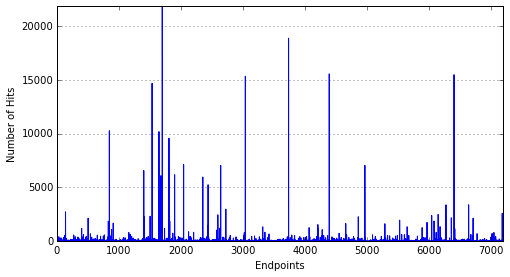

In [12]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
axis([0, len(ends), 0, max(counts)])
grid(b=True, which='major', axis='y')
xlabel('Endpoints')
ylabel('Number of Hits')
plot(counts)

#### **Частые ресурсы**

In [13]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print('Top Ten Endpoints: %s' % topEndpoints)

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 21854), (u'/images/KSC-logosmall.gif', 18893), (u'/images/MOSAIC-logosmall.gif', 15568), (u'/images/USA-logosmall.gif', 15488), (u'/images/WORLD-logosmall.gif', 15351), (u'/images/ksclogo-medium.gif', 14687), (u'/history/apollo/images/apollo-logo1.gif', 10262), (u'/ksc.html', 10182), (u'/images/launch-logo.gif', 9568), (u'/', 7108)]


### **Часть 3: Анализ серверных лог-файлов**

#### **10 самых частых ресурсов, обращение к которым вызывало ошибку**
#### Каковы 10 ресурсов (endpoints), при обращении к которым код ответа был не 200? Создайте отсортированный список с 10 самыми частыми ресурсами и числом обращений к ним с кодом ответа, отличным от 200. 

In [14]:
not200 = access_logs.filter(lambda log: log.response_code != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1)).cache()

endpointSum = endpointCountPairTuple.reduceByKey(lambda a,b: a+b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])
print('Top Ten failed URLs: %s' % topTenErrURLs)

Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 3380), (u'/images/KSC-logosmall.gif', 2658), (u'/images/MOSAIC-logosmall.gif', 1915), (u'/images/USA-logosmall.gif', 1891), (u'/images/WORLD-logosmall.gif', 1811), (u'/images/ksclogo-medium.gif', 1794), (u'/history/apollo/images/apollo-logo1.gif', 1106), (u'/images/launch-logo.gif', 1088), (u'/', 863), (u'/shuttle/missions/sts-69/sts-69-patch-small.gif', 678)]


#### **Число уникальных адресов**
#### Сколько всего уникальных хостов в лог-файле?

In [15]:
hosts = (access_logs
        .map(lambda log: log.host)
        )

uniqueHosts = hosts.distinct()

uniqueHostCount = uniqueHosts.count()
print('Unique hosts: %d' % uniqueHostCount)

Unique hosts: 23315


### Часть 4: Исследование запросов с кодом ответа 404

#### Создайте RDD c запросами лога, имеющими код ответа сервера 404. Закэшируйте RDD `badRecords`.

In [16]:
badRecords = (access_logs
              .filter(lambda log: log.response_code == 404)).cache()
print('Found %d 404 URLs' % badRecords.count())

Found 1940 404 URLs


#### Выведите 40 уникальных ресурсов, обращение к которым вызвало статус 404

In [17]:
badEndpoints = badRecords.map(lambda log: log.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print('404 URLS: %s' % badUniqueEndpointsPick40)

404 URLS: [u'/shuttle/missions/sts-71/images/KSC-95EC-0916.txt', u'/ico', u'/shuttle/missions/mission.html/', u'/shuttle/missions/sts-69/images/images/html', u'/shuttle/missions/sts-59/missions-sts-59.html', u'/spftware/winvn/winvn.html/', u"/shuttle/technology/sts-newsref/sts-jsc.html'", u'/shuttle/missions/sts-69/mission-sts-74.html', u'/history/discovery', u'/images/lf.gif', u'/shuttle/missions/sts-67/images/k95p0391.gif></a>', u'/IMAGES/', u'/shuttle/missions/sts-69/images/images.ht', u'/history/apollo/apollo-13/html', u'/shuttle/missions/sts-73.html', u'/procurement/business/ciao1.htm', u'/icons/blank', u'/shuttle/missions/STS-69/mission-STS-69.html', u'/persons/astronauts/thagar.html', u'/images/jpeg/', u'/history/apollo/apollo-13/apollo_13.html', u'/technology/', u'/icons/AOL.gif', u'/eggfl.hmtl', u'/shuttle.nasa.gov', u'/KSC.html', u'/elv/SCOUT/elvhead2.gif', u'/pub/win3/winvn/wv16_99.04.zip', u'/history/apollo/sa-9/images/', u'/pub/win3/winvn/', u'/elv/DELTA/uncons.htm', u'/so

#### Создайте список топ 20 ресурсов, обращение к которым вызвало статус 404.

In [18]:
badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint,1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a,b: a+b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20,lambda s: -1 * s[1])
print('Top Twenty 404 URLs: %s' % badEndpointsTop20)

Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 195), (u'/shuttle/missions/STS-69/mission-STS-69.html', 167), (u'/pub/winvn/release.txt', 163), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 64), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 51), (u'/images/crawlerway-logo.gif', 44), (u'/elv/DELTA/uncons.htm', 42), (u'/history/apollo/a-001/a-001-patch-small.gif', 42), (u'/://spacelink.msfc.nasa.gov', 39), (u'/history/apollo/images/little-joe.jpg', 30), (u'/shuttle/resources/orbiters/challenger.gif', 24), (u'/shuttle/resources/orbiters/discovery.gif', 24), (u'/shuttle/resources/orbiters/atlantis.gif', 19), (u'/history/apollo/sa-2/sa-2-patch-small.gif', 19), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 19), (u'/images/lf-logo.gif', 18), (u'/elv/new01.gif>', 15), (u'/icons/image.xb', 14), (u'/software/winvn/winvn.html.', 14), (u'/robots.txt', 14)]


#### Создайте список топ 25 адресов, обращение к которым вызвало статус 404.

In [19]:
errHostsCountPairTuple = badRecords.map(lambda log: (log.host,1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a,b: a+b)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda s: -1 * s[1])
print('Top 25 hosts that generated errors: %s' % errHostsTop25)

Top 25 hosts that generated errors: [(u'maz3.maz.net', 33), (u'spica.sci.isas.ac.jp', 27), (u'slip145-189.ut.nl.ibm.net', 22), (u'163.206.104.34', 18), (u'bombasto.informatik.rwth-aachen.de', 15), (u'dialup07.smartnet.net', 14), (u'205.138.53.104', 14), (u'redx3.cac.washington.edu', 14), (u'etd5a.cad.ksc.nasa.gov', 13), (u'envpow182.innopoli.fi', 12), (u'tgiwall.tg-inet.co.jp', 12), (u'pc6083-bh.nwscc.sea06.navy.mil', 11), (u'206.27.25.1', 11), (u'piweba3y.prodigy.com', 11), (u'mahalaha_a.lmig.com', 10), (u'unix.ka9q.ampr.org', 10), (u'199.174.158.13', 10), (u'204.144.151.118', 9), (u'gatekeeper.uccu.com', 9), (u'www-b5.proxy.aol.com', 8), (u'p90.allbiz.com', 8), (u'scooter.pa-x.dec.com', 8), (u'152.163.192.38', 8), (u'demornay.lanl.gov', 8), (u'129.186.97.20', 7)]


#### Посчитайте число запросов со статусом 404 в день 

In [20]:
errDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day,1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda a,b: a+b)

errDateSorted = (errDateSum
                 .sortByKey()).cache()
errByDate = errDateSorted.collect()
print('404 Errors by day: %s' % errByDate)

404 Errors by day: [(8, 93), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 293)]


#### Отображение числа запросов со статусом 404 в день 

In [21]:
daysWithErrors404 = errDateSorted.map(lambda (day, errors): day).collect()
errors404ByDay = errDateSorted.map(lambda (day, errors): errors).collect()

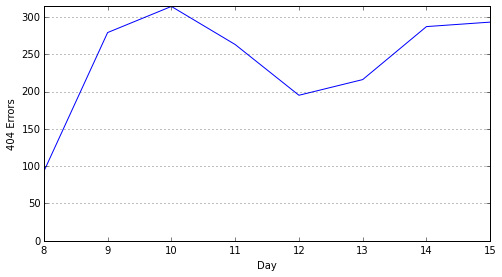

In [23]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([8, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)